In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal, Dirichlet

In [2]:
from edward.models import RandomVariable
from tensorflow.python.framework import dtypes
from tensorflow.contrib.distributions import Distribution, NOT_REPARAMETERIZED

class distributions_OrdinalLogit(Distribution):
    def __init__(self, logits, cutpoints, name="OrdinalLogit"):
        self._logits = logits
        self._cutpoints = cutpoints
        
        parameters = dict(locals())
        super(distributions_OrdinalLogit, self).__init__(
            dtype=dtypes.int32,
            reparameterization_type=NOT_REPARAMETERIZED,
            validate_args=False,
            allow_nan_stats=True,
            parameters=parameters,
            graph_parents=[self._logits, self._cutpoints],
            name=name
        )

    def _data_size(self):
        return tf.size(self._logits)
        
    def _cumul_probs(self):
        logits_with_cutpoints = tf.expand_dims(self._logits, -1) + self._cutpoints  # using broadcasting
        return tf.sigmoid(logits_with_cutpoints)
        
    def _log_prob(self, value):        
        cumul_probs = self._cumul_probs()
        level_probs = tf.concat([cumul_probs, tf.expand_dims(tf.ones([self._data_size()]), -1)], axis=1) - \
                        tf.concat([tf.expand_dims(tf.zeros([self._data_size()]), -1), cumul_probs], axis=1)
        levels = value
        indices_2d = tf.transpose(tf.stack([tf.range(self._data_size()), levels]))  # n x 2
        selected_probs = tf.gather_nd(level_probs, indices_2d)
        
        return tf.reduce_sum(tf.log(selected_probs))
    
    def _sample_n(self, n, seed=None):
        cumul_probs = self._cumul_probs()
        new_shape = [n, self._data_size()]
        sample_probs = tf.expand_dims(tf.random_uniform(new_shape), -1)
        booleans = tf.greater(sample_probs, cumul_probs)  # using broadcasting
        samples = tf.reduce_sum(tf.cast(booleans, dtype=dtypes.int32), axis=-1)
        return samples
    
    def mean(self):
        # Using the identity that the mean is \sum_{i=0}^k P(X > i)
        cumul_probs = self._cumul_probs()
        means = tf.reduce_sum(1-cumul_probs, axis=1)
        return means
        

def __init__(self, *args, **kwargs):
    RandomVariable.__init__(self, *args, **kwargs)

_name = 'OrdinalLogit'
_candidate = distributions_OrdinalLogit
__init__.__doc__ = _candidate.__init__.__doc__
_globals = globals()
_params = {'__doc__': _candidate.__doc__,
           '__init__': __init__,
           'support': 'countable'}
_globals[_name] = type(_name, (RandomVariable, _candidate), _params)

In [3]:
class FLAGS:
    N=50
    M=60
    D=3
    N_CUT=5

In [4]:
def build_toy_dataset(U, V, N, M, noise_std=0.1, max_val=5):
    R = np.dot(np.transpose(U), V) + np.random.normal(0, noise_std, size=(N, M))
    return np.round(np.clip(R, 0, max_val)).astype(int)


def get_indicators(N, M, prob_std=0.5):
    ind = np.random.binomial(1, prob_std, (N, M))
    return ind

def logit(p):
    return tf.log(p / (1-p))

In [5]:
ed.set_seed(2018)

# true latent factors
U_true = np.random.randn(FLAGS.D, FLAGS.N)
V_true = np.random.randn(FLAGS.D, FLAGS.M)
# add some structure to latent factors
U_true[:,:FLAGS.N//2] += 0.5
U_true[:,FLAGS.N//2:] -= 0.5
V_true[:,:FLAGS.M//2] += 0.5
V_true[:,FLAGS.M//2:] -= 0.5

# DATA
R_true = build_toy_dataset(U_true, V_true, FLAGS.N, FLAGS.M, max_val=FLAGS.N_CUT)
I_train = get_indicators(FLAGS.N, FLAGS.M).astype(bool)

# MODEL
I = tf.placeholder(tf.float32, [FLAGS.N, FLAGS.M])
U = Normal(loc=0.0, scale=1.0, sample_shape=[FLAGS.D, FLAGS.N])
V = Normal(loc=0.0, scale=1.0, sample_shape=[FLAGS.D, FLAGS.M])
# R = Normal(loc=tf.matmul(tf.transpose(U), V) * I,
#            scale=tf.ones([FLAGS.N, FLAGS.M]))
# R = Bernoulli(logits=tf.matmul(tf.transpose(U), V) * I)

logits = tf.boolean_mask(tf.matmul(tf.transpose(U), V), I)
cutpoints = tf.placeholder(tf.float32, [FLAGS.N_CUT])
R = OrdinalLogit(logits=logits, cutpoints=cutpoints)

# INFERENCE
qU = Normal(loc=tf.get_variable("qU/loc", [FLAGS.D, FLAGS.N]),
          scale=tf.nn.softplus(
              tf.get_variable("qU/scale", [FLAGS.D, FLAGS.N])))
qV = Normal(loc=tf.get_variable("qV/loc", [FLAGS.D, FLAGS.M]),
          scale=tf.nn.softplus(
              tf.get_variable("qV/scale", [FLAGS.D, FLAGS.M])))

R_train = R_true[I_train]
test_cutpoints = np.linspace(-4, 4, FLAGS.N_CUT)
inference = ed.KLqp({U: qU, V: qV}, data={R: R_train, I: I_train, cutpoints: test_cutpoints})
inference.run()

# CRITICISM
# qR = OrdinalLogit(
#     logits=tf.boolean_mask(Normal(loc=tf.matmul(tf.transpose(qU), qV), scale=tf.ones([FLAGS.N, FLAGS.M])), I),
#     cutpoints=cutpoints
# )
qR = OrdinalLogit(
    logits=tf.boolean_mask(tf.matmul(tf.transpose(qU), qV), I),
    cutpoints=cutpoints
)

R_test = R_true[~I_train]
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={qR: R_test, I: ~I_train, cutpoints: test_cutpoints}))

/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


  30/1000 [  3%]                                ETA: 14s | Loss: 2575.797

/Users/cyz/edward/edward/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 1730.585
Mean squared error on test data:
0.49097425


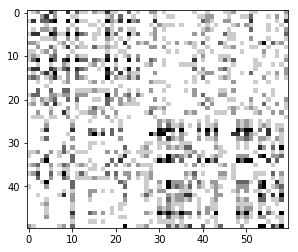

In [6]:
plt.imshow(R_true / FLAGS.N_CUT, cmap='binary')
plt.show()

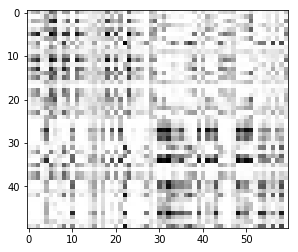

In [7]:
# evaluate at posterior mean
R_est = OrdinalLogit(
            logits=tf.reshape(tf.matmul(tf.transpose(qU), qV), [-1]),
            cutpoints=cutpoints
        ).mean().eval({cutpoints: test_cutpoints}).reshape(R_true.shape)
plt.imshow(R_est / FLAGS.N_CUT, cmap='binary')
plt.show()